In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')
import random

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

from util import array2mat

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
map_info = pd.read_csv('/lmh_data/data/sclab/sclab/map_result.csv', sep='\t', index_col=0)
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})

gene_name = 'ENPP2'
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/tmp/{}/evaluate.npy'.format(gene_name), allow_pickle=True)

In [3]:
rna = rna[map_info.index]
rna = rna[rna.obs['cell_type'].isin(['ODC']),:]
rna.layers["counts"] = rna.X.copy()

In [4]:
_index = []
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
#     if eval_set[i]['cell_type'] in ['Endo']:
#         continue
    if eval_set[i]['cell_type'] not in ['ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            _index.append(_rna[j].obs.index[0])
            
rna = rna[_index]
rna

View of AnnData object with n_obs × n_vars = 230 × 50281
    obs: 'cell_type', 'domain'
    layers: 'counts'

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be

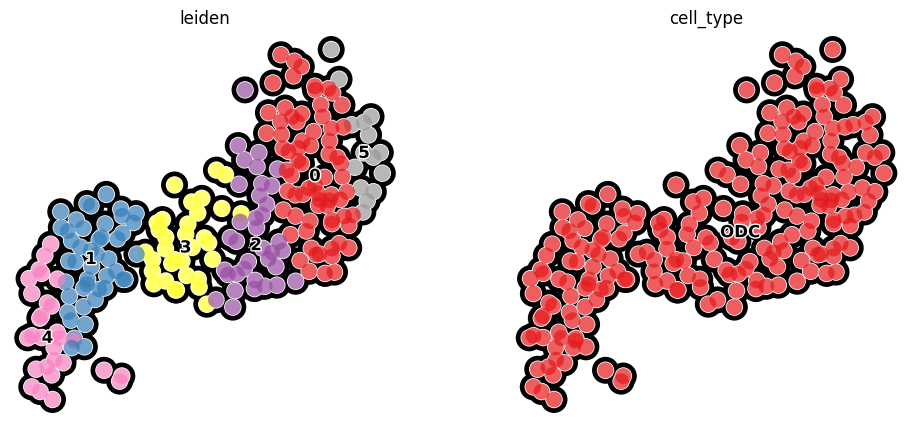

In [5]:
rna.X = rna.layers["counts"].copy()
# sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
# sc.pp.normalize_total(rna)
# sc.pp.log1p(rna)
# sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.tl.leiden(rna)

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

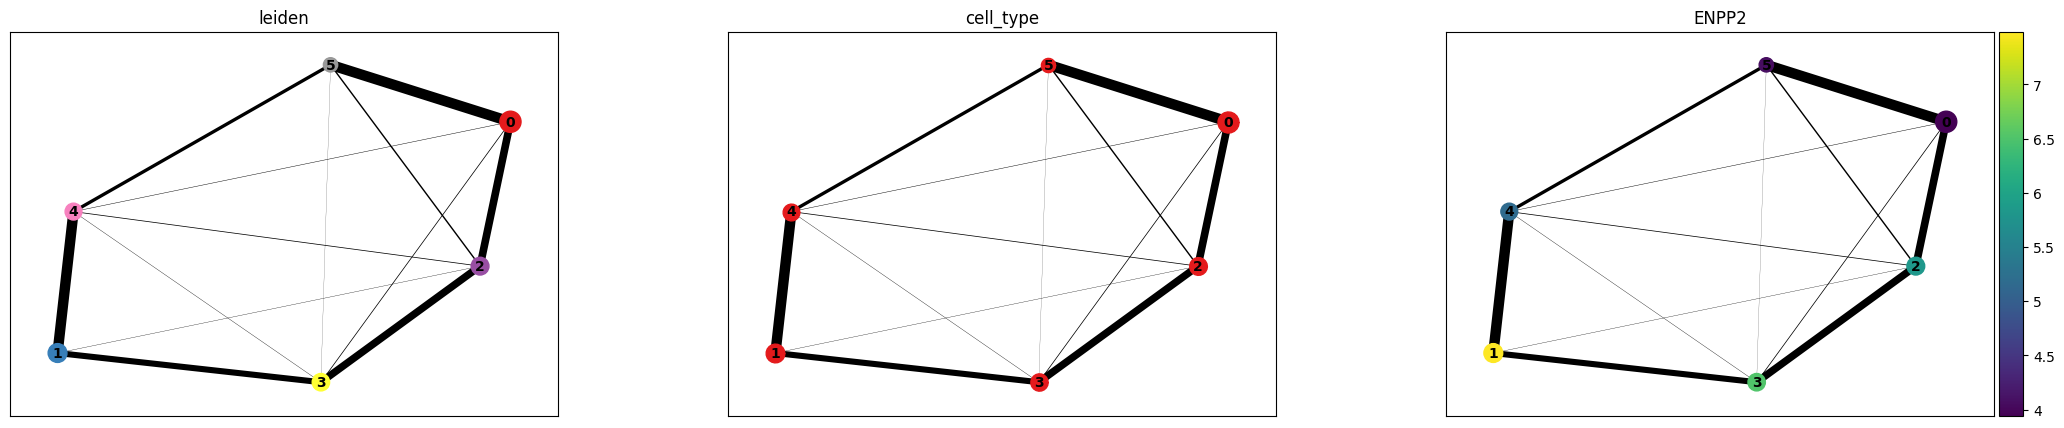

In [6]:
sc.tl.paga(rna, groups='leiden')
sc.pl.paga(rna, color=['leiden', 'cell_type', gene_name])

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


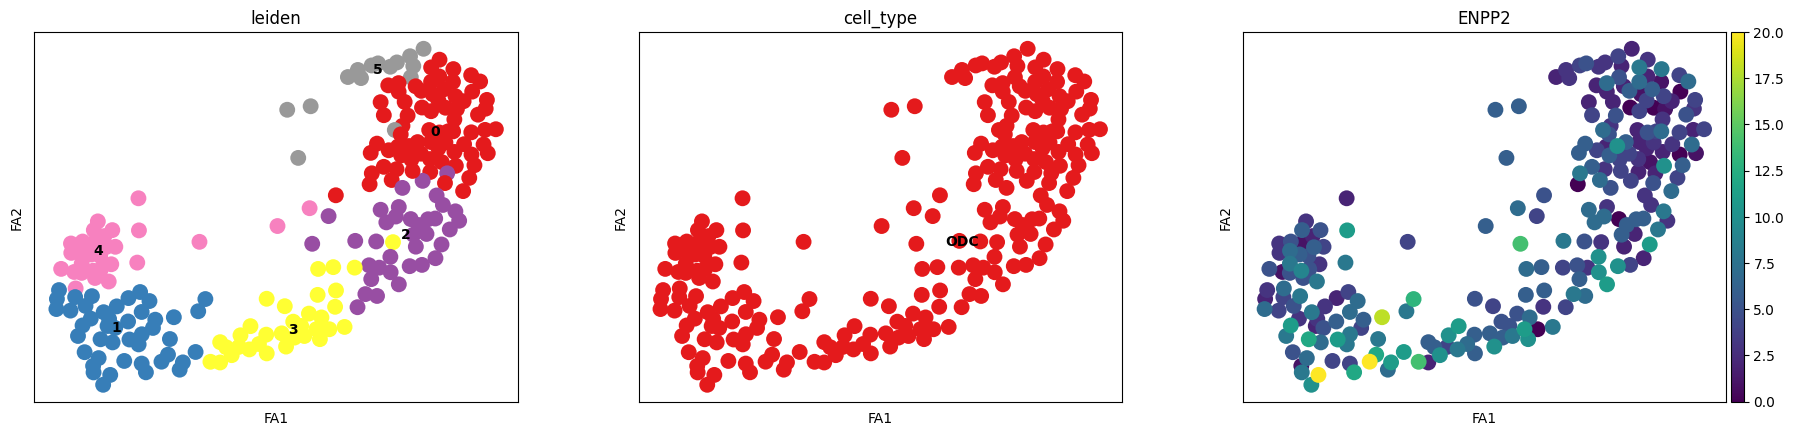

In [7]:
sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', gene_name], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


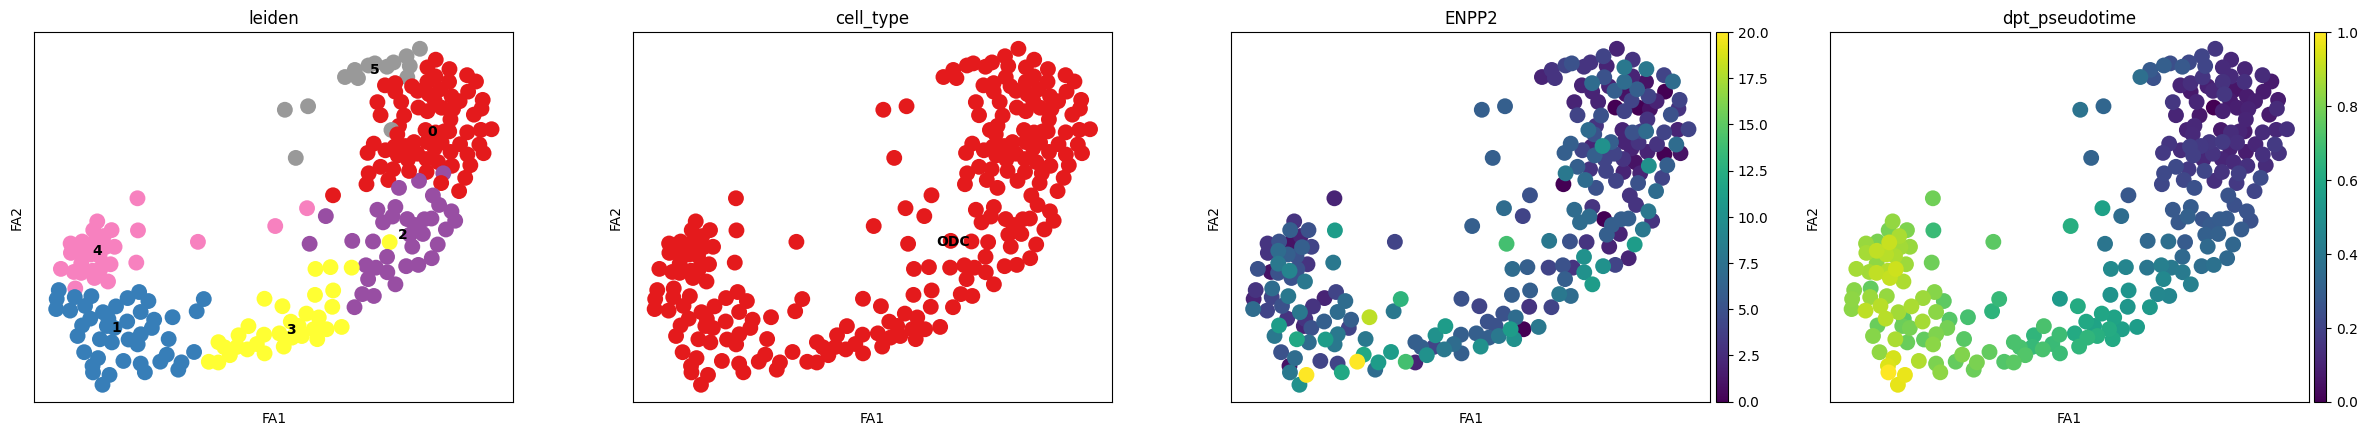

In [8]:
rna.uns['iroot'] = np.flatnonzero(rna.obs['leiden']=='0')[0]
sc.tl.dpt(rna)

sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', gene_name, 'dpt_pseudotime'], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


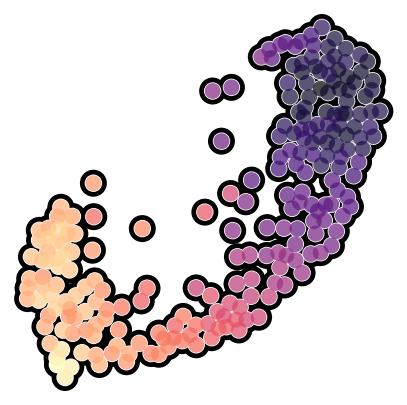

In [9]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.draw_graph(rna, color=['dpt_pseudotime'], cmap='magma',
                     add_outline=True, legend_loc=None, colorbar_loc=None, title='', frameon=False, return_fig=True)
#     plt.savefig(
#         '/lmh_data/work/SEE/analyse/figure_file/pseudotime({}).pdf'.format(gene_name),
#         format='pdf', bbox_inches='tight')
    plt.show()

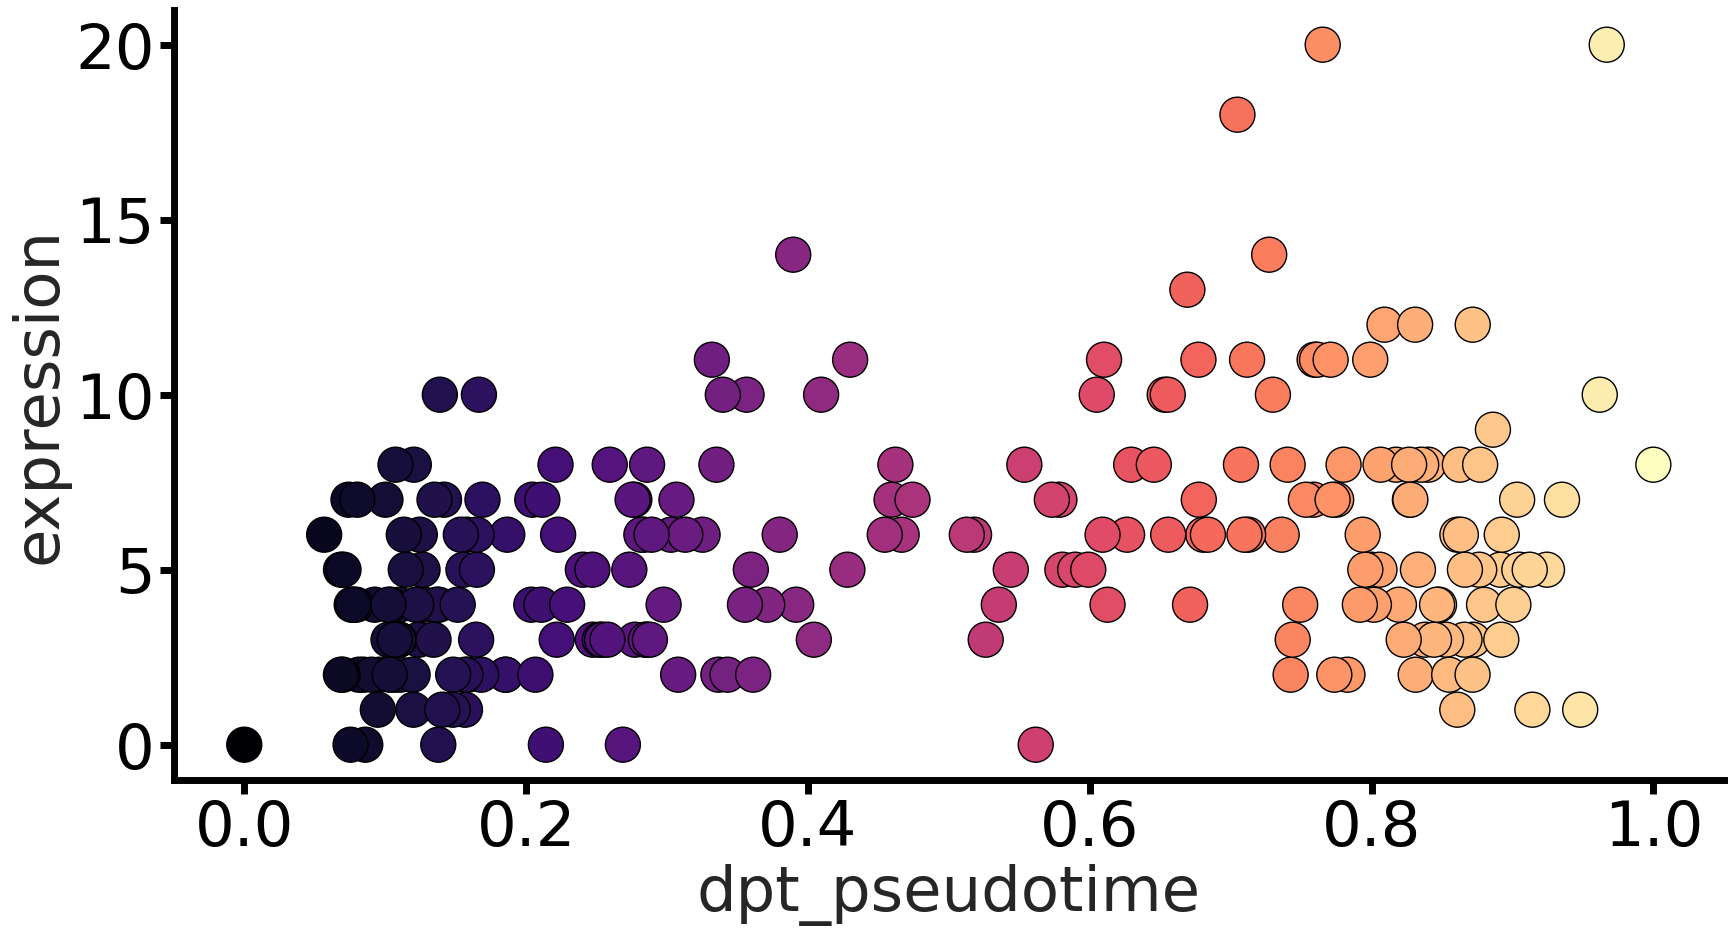

In [10]:
import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

set_plt(figsize=(20, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

_x, _y = rna.obs['dpt_pseudotime'].values, rna[:, gene_name].layers["counts"].reshape(-1)
ax.scatter(_x, _y, edgecolors='black', s=(figure_size['large']*72./fig.dpi)**2, c=_x, cmap='magma')

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
plt.xlabel('dpt_pseudotime', fontsize=figure_size['ultra'])
plt.ylabel('expression', fontsize=figure_size['ultra'])
plt.savefig(
    '/lmh_data/work/SEE/analyse/figure_file/{} expression(ODC).pdf'.format(gene_name),
    format='pdf', bbox_inches='tight')
plt.show()

In [11]:
scHiC = {}
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in ['ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            scHiC[_rna[j].obs_names[0]] = preds[i]['predict']
            break
scHiC

{'CTAAGTGGTGTCCAAT-LKTX_190130_01_F01': array([ 3.35296124e-01,  3.17366421e-03,  1.52589399e-02,  2.11811699e-02,
        -2.47795433e-02, -8.87107104e-04, -9.59728844e-03,  9.10031050e-03,
         4.35733236e-03, -2.71743443e-02,  6.45585172e-03, -1.20602176e-02,
        -9.34146717e-03, -2.07403712e-02,  4.47879970e-01,  3.38639170e-02,
         1.23955086e-02,  1.30515341e-02,  1.32033546e-02,  8.77689198e-03,
         3.44865769e-03, -1.19460039e-02,  6.22826442e-03, -4.76107001e-04,
         8.52714758e-03,  2.60112714e-02,  1.00001544e-02,  4.36254323e-01,
         1.81834903e-02,  7.99506623e-03, -1.09497542e-02,  1.29136387e-02,
         1.77627839e-02, -1.74814835e-04,  1.05541609e-02,  4.02082503e-03,
         1.35350432e-02,  1.29872747e-02,  1.85162127e-02,  4.69355881e-01,
         3.06076631e-02, -5.92313148e-03,  1.48241501e-02,  3.25092599e-02,
         1.14059336e-02, -6.70142472e-05,  2.76800189e-02, -1.53341554e-02,
        -6.08301908e-03, -2.76688971e-02,  4.7332

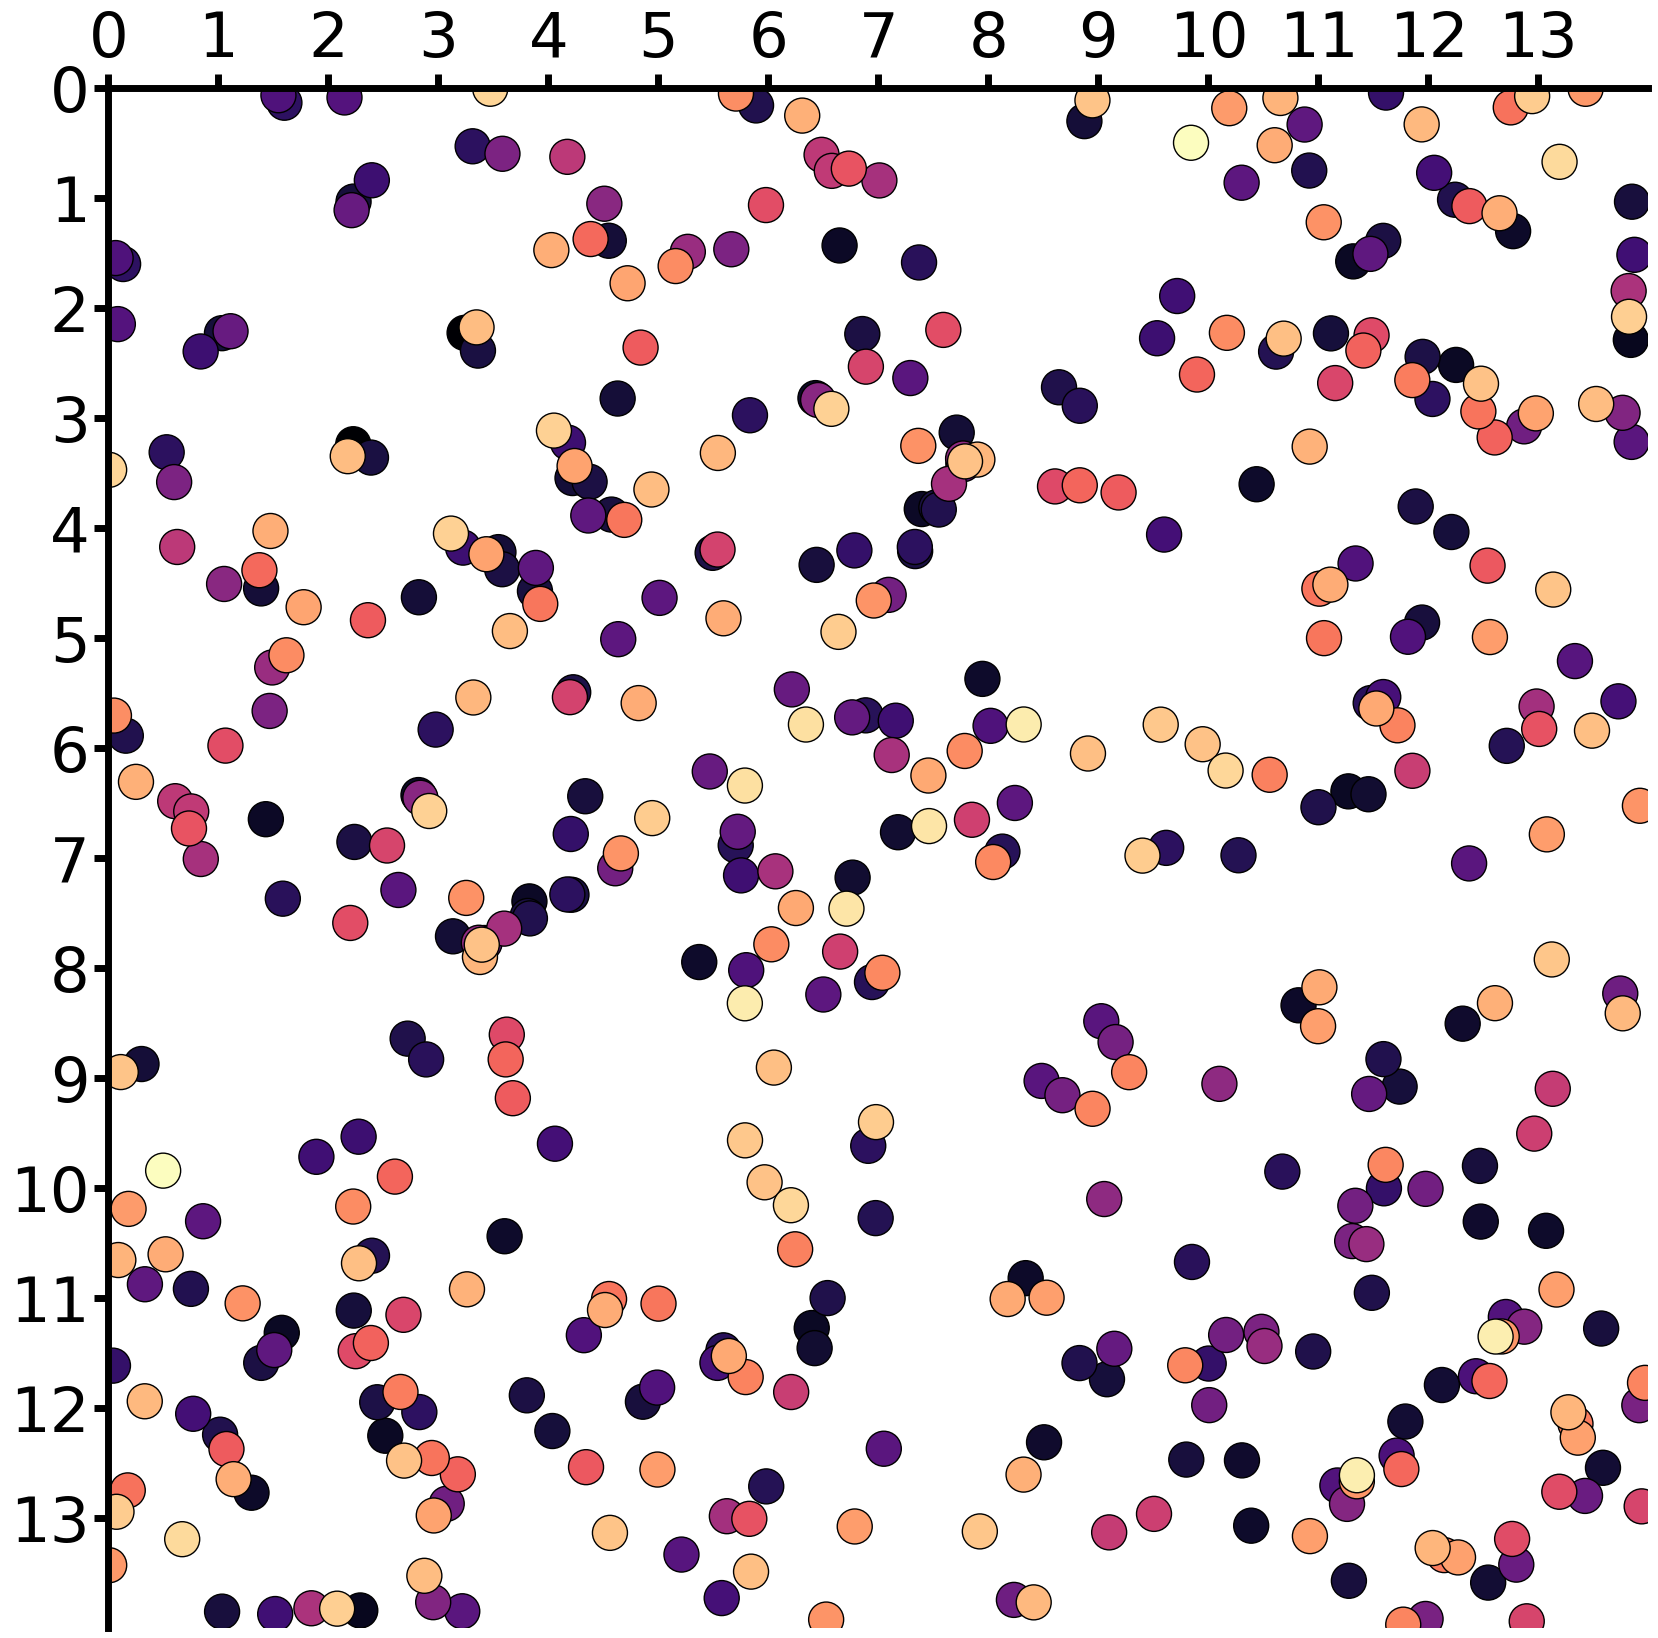

In [12]:
set_plt(figsize=(20, 20))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
set_Border(plt.gca())

_scatter_xs, _scatter_ys = [], []
_pseudotimes = []
for rna_name in rna.obs.sort_values(by='dpt_pseudotime').index:
    if rna_name not in scHiC.keys():
        continue
    _pseudotime = rna[rna_name].obs['dpt_pseudotime'].values[0]
    _hic = array2mat(scHiC[rna_name]).copy()
    _hic += abs(_hic.min())
    
    _where = np.where(np.ones(_hic.shape))
    _where = list(zip(_where[0], _where[1]))
    _test = np.zeros(len(_where), dtype=object)
    for i in range(len(_where)):
        _test[i] = _where[i]
    _where = _test
    _p = np.triu(_hic, 1).reshape(-1)
    _p /= _p.sum()

    _scatter_x, _scatter_y = [], []
    for (i, j) in np.random.choice(_where, 1, p=_p):
        _i, _j = random.random()+i, random.random()+j
        if i == j:
            _i, _j = max(_i, _j), min(_i, _j)
        _scatter_x.append(_i)
        _scatter_y.append(_j)

    _i, _j = _scatter_x.copy(), _scatter_y.copy()
    _scatter_x.extend(_j), _scatter_y.extend(_i)

    _scatter_xs.extend(_scatter_x), _scatter_ys.extend(_scatter_y)
    _pseudotimes.extend([_pseudotime]*len(_scatter_x))

plt.scatter(_scatter_xs, _scatter_ys, edgecolors='black',
            s=(figure_size['large']*72./fig.dpi)**2, c=_pseudotimes, cmap='magma')

_len = array2mat(scHiC.get(next(iter(scHiC)))).shape[0]
plt.xticks([i for i in range(_len)])
plt.yticks([i for i in range(_len)])
plt.xlim((0, _len))
plt.ylim((0, _len))

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('none')
ax.spines['top'].set_linewidth(figure_size['very_small'])

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')

plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
plt.savefig(
    '/lmh_data/work/SEE/analyse/figure_file/{} heatmap(ODC).pdf'.format(gene_name),
    format='pdf', bbox_inches='tight')
plt.show()

In [13]:
_partition = [
    rna.obs[rna.obs.dpt_pseudotime<=0.5],
    rna.obs[rna.obs.dpt_pseudotime>0.5]
]

pseudo_bulk_hic = []

for i in range(len(_partition)):
    _pseudo_bulk = None
    for rna_name in _partition[i].index:
        if rna_name not in scHiC.keys():
            continue

        _hic = array2mat(scHiC[rna_name]).copy()
        _hic += abs(_hic.min())
        if _pseudo_bulk is None:
            _pseudo_bulk = _hic
        else:
            _pseudo_bulk += _hic

    pseudo_bulk_hic.append(_pseudo_bulk / len(_partition[i]))
pseudo_bulk_hic

[array([[0.3197328782, 0.0390346704, 0.0488812001, 0.0463850683,
         0.0090298169, 0.0361963209, 0.0366821996, 0.0358489076,
         0.0375951644, 0.0068630818, 0.041287498 , 0.0272697667,
         0.0290851024, 0.0149301587],
        [0.0390346704, 0.4685627314, 0.0594768581, 0.0394004742,
         0.0420146095, 0.045488646 , 0.0391606084, 0.0350209523,
         0.0172173861, 0.0374986313, 0.0442784111, 0.0398083181,
         0.0511009655, 0.0457175401],
        [0.0488812001, 0.0594768581, 0.4029240963, 0.0394508058,
         0.040749297 , 0.0191327458, 0.0452571203, 0.0463560498,
         0.0315895686, 0.0391004435, 0.0369667347, 0.039751229 ,
         0.0427205577, 0.0464166306],
        [0.0463850683, 0.0394004742, 0.0394508058, 0.435017365 ,
         0.0626799131, 0.0265356841, 0.0430504126, 0.0696432554,
         0.0380949883, 0.0389838461, 0.0484256291, 0.0203554168,
         0.0328088173, 0.0089792143],
        [0.0090298169, 0.0420146095, 0.040749297 , 0.0626799131,
   

In [14]:
import os
import tempfile

def _draw(mat, title=None, ignore_diag=False):
    set_plt(figsize=(10, 10))
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots()
    
    if ignore_diag:
        mat = mat.copy()
        np.fill_diagonal(mat, 0)
    ax = sns.heatmap(mat, cmap='Greys', square=True)

    set_Border(plt.gca())
    plt.grid(False)
    
    ax.set_xticks([])
    ax.set_yticks([])

    if title:
        plt.savefig(
            '/lmh_data/work/SEE/analyse/figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()
    
def Calculate_chromatin_conformation(mat, out_dir):
    ftmp = tempfile.NamedTemporaryFile(delete=False)
    print(ftmp.name)
    with open(ftmp.name, 'w') as f:
        _strs = []
        for i in range(mat.shape[0]):
            _strs.append(','.join([str(j) for j in mat[i]])+'\n')
        f.writelines(_strs)

    os.makedirs(out_dir, exist_ok=True)
    with open('parameters.txt', 'w') as f:
        f.writelines([
            'NUM = 1\n', 'OUTPUT_FOLDER = {}\n'.format(out_dir), 'INPUT_FILE = {}\n'.format(ftmp.name),
            'VERBOSE = true\n', 'LEARNING_RATE = 1\n', 'MAX_ITERATION = 10000\n'
        ])

    os.system('java -jar /lmh_data/work/SEE/analyse/3DMax/3DMax.jar parameters.txt')

    os.remove(ftmp.name)
    os.remove('parameters.txt')

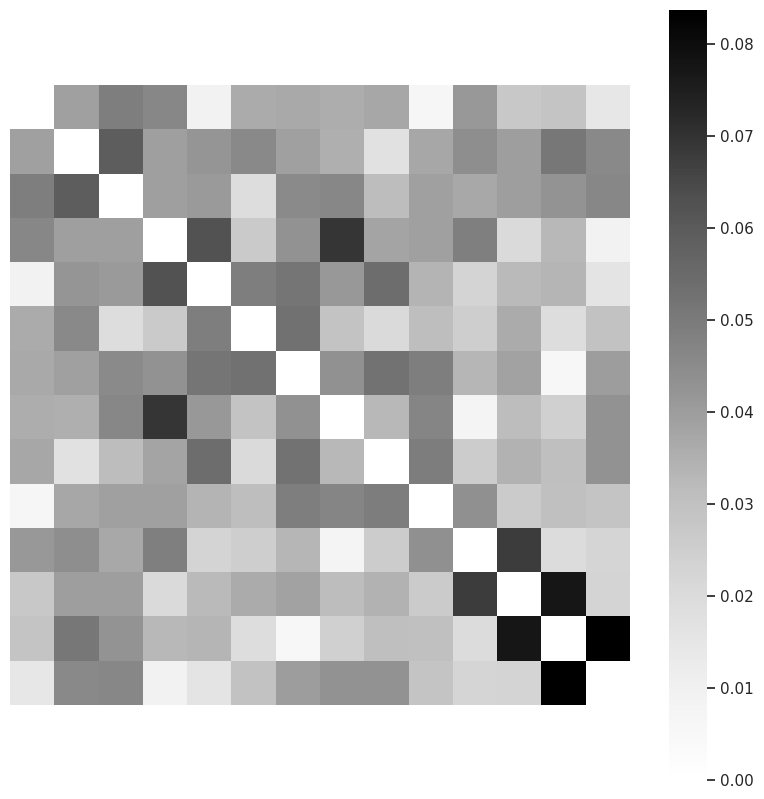

/tmp/tmpyqy54v2q
3DMax for Genome Structure.
INSTRUCTION:
 (1) Input the file containing the parameters. 

Conversion to List Successful, New File = InputData_in_TupleFormat.txt
Number of points: 14
Number of constraints: 91
Max distance is: 11.821178446919458
Number of processors:1
Iteration 1, objective function:-48.54942, length of gradient 0.5209838
Iteration 2, objective function:-44.73259, length of gradient 0.6509495
Iteration 3, objective function:-40.92829, length of gradient 0.7919362
Iteration 4, objective function:-37.57853, length of gradient 0.9041606
Iteration 5, objective function:-35.39134, length of gradient 0.8567133
Iteration 6, objective function:-34.28947, length of gradient 0.6264661
Iteration 7, objective function:-33.71143, length of gradient 0.4414548
Iteration 8, objective function:-33.40570, length of gradient 0.3231987
Iteration 9, objective function:-33.24172, length of gradient 0.2375874
Iteration 10, objective function:-33.14670, length of gradient 0.180

Iteration 251, objective function:-32.25914, length of gradient 0.0294355
Iteration 252, objective function:-32.25603, length of gradient 0.0298748
Iteration 253, objective function:-32.25285, length of gradient 0.0302915
Iteration 254, objective function:-32.24960, length of gradient 0.0306829
Iteration 255, objective function:-32.24628, length of gradient 0.0310459
Iteration 256, objective function:-32.24290, length of gradient 0.0313776
Iteration 257, objective function:-32.23946, length of gradient 0.0316750
Iteration 258, objective function:-32.23597, length of gradient 0.0319350
Iteration 259, objective function:-32.23245, length of gradient 0.0321543
Iteration 260, objective function:-32.22890, length of gradient 0.0323298
Iteration 261, objective function:-32.22533, length of gradient 0.0324583
Iteration 262, objective function:-32.22174, length of gradient 0.0325367
Iteration 263, objective function:-32.21816, length of gradient 0.0325621
Iteration 264, objective function:-32.

Iteration 1, objective function:-48.57559, length of gradient 0.5235898
Iteration 2, objective function:-44.79446, length of gradient 0.6499843
Iteration 3, objective function:-41.04644, length of gradient 0.7845510
Iteration 4, objective function:-37.80613, length of gradient 0.8833324
Iteration 5, objective function:-35.85072, length of gradient 0.8021825
Iteration 6, objective function:-35.11321, length of gradient 0.5120117
Iteration 7, objective function:-34.78816, length of gradient 0.3148518
Iteration 8, objective function:-34.59150, length of gradient 0.2402873
Iteration 9, objective function:-34.45685, length of gradient 0.1990519
Iteration 10, objective function:-34.35738, length of gradient 0.1718989
Iteration 11, objective function:-34.28038, length of gradient 0.1520395
Iteration 12, objective function:-34.21888, length of gradient 0.1364192
Iteration 13, objective function:-34.16857, length of gradient 0.1236694
Iteration 14, objective function:-34.12654, length of gradie

Iteration 292, objective function:-32.05288, length of gradient 0.0036258
Iteration 293, objective function:-32.05284, length of gradient 0.0036044
Iteration 294, objective function:-32.05279, length of gradient 0.0035834
Iteration 295, objective function:-32.05275, length of gradient 0.0035627
Iteration 296, objective function:-32.05271, length of gradient 0.0035424
Iteration 297, objective function:-32.05267, length of gradient 0.0035224
Iteration 298, objective function:-32.05263, length of gradient 0.0035029
Iteration 299, objective function:-32.05259, length of gradient 0.0034837
Iteration 300, objective function:-32.05255, length of gradient 0.0034649
Iteration 301, objective function:-32.05251, length of gradient 0.0034465
Iteration 302, objective function:-32.05247, length of gradient 0.0034285
Iteration 303, objective function:-32.05243, length of gradient 0.0034109
Iteration 304, objective function:-32.05239, length of gradient 0.0033936
Iteration 305, objective function:-32.

Iteration 1467, objective function:-31.89184, length of gradient 0.0070000
Iteration 1468, objective function:-31.89167, length of gradient 0.0070542
Iteration 1469, objective function:-31.89151, length of gradient 0.0071083
Iteration 1470, objective function:-31.89134, length of gradient 0.0071625
Iteration 1471, objective function:-31.89117, length of gradient 0.0072167
Iteration 1472, objective function:-31.89099, length of gradient 0.0072709
Iteration 1473, objective function:-31.89082, length of gradient 0.0073251
Iteration 1474, objective function:-31.89064, length of gradient 0.0073793
Iteration 1475, objective function:-31.89045, length of gradient 0.0074335
Iteration 1476, objective function:-31.89027, length of gradient 0.0074877
Iteration 1477, objective function:-31.89008, length of gradient 0.0075420
Iteration 1478, objective function:-31.88989, length of gradient 0.0075962
Iteration 1479, objective function:-31.88970, length of gradient 0.0076504
Iteration 1480, objective

Iteration 708, objective function:-30.65883, length of gradient 0.0038781
Iteration 709, objective function:-30.65879, length of gradient 0.0038532
Iteration 710, objective function:-30.65875, length of gradient 0.0038284
Iteration 711, objective function:-30.65871, length of gradient 0.0038037
Iteration 712, objective function:-30.65867, length of gradient 0.0037791
Iteration 713, objective function:-30.65864, length of gradient 0.0037545
Iteration 714, objective function:-30.65860, length of gradient 0.0037300
Iteration 715, objective function:-30.65856, length of gradient 0.0037056
Iteration 716, objective function:-30.65853, length of gradient 0.0036813
Iteration 717, objective function:-30.65849, length of gradient 0.0036570
Iteration 718, objective function:-30.65846, length of gradient 0.0036328
Iteration 719, objective function:-30.65842, length of gradient 0.0036087
Iteration 720, objective function:-30.65839, length of gradient 0.0035847
Iteration 721, objective function:-30.

Iteration 61, objective function:-31.67706, length of gradient 0.0853710
Iteration 62, objective function:-31.65658, length of gradient 0.0846357
Iteration 63, objective function:-31.63622, length of gradient 0.0842283
Iteration 64, objective function:-31.61578, length of gradient 0.0841794
Iteration 65, objective function:-31.59504, length of gradient 0.0845296
Iteration 66, objective function:-31.57375, length of gradient 0.0853248
Iteration 67, objective function:-31.55161, length of gradient 0.0866107
Iteration 68, objective function:-31.52830, length of gradient 0.0884232
Iteration 69, objective function:-31.50348, length of gradient 0.0907792
Iteration 70, objective function:-31.47678, length of gradient 0.0936663
Iteration 71, objective function:-31.44785, length of gradient 0.0970343
Iteration 72, objective function:-31.41640, length of gradient 0.1007901
Iteration 73, objective function:-31.38219, length of gradient 0.1047979
Iteration 74, objective function:-31.34510, length 

Iteration 869, objective function:-30.55386, length of gradient 0.0029046
Iteration 870, objective function:-30.55383, length of gradient 0.0029284
Iteration 871, objective function:-30.55381, length of gradient 0.0029524
Iteration 872, objective function:-30.55378, length of gradient 0.0029766
Iteration 873, objective function:-30.55375, length of gradient 0.0030009
Iteration 874, objective function:-30.55372, length of gradient 0.0030254
Iteration 875, objective function:-30.55369, length of gradient 0.0030501
Iteration 876, objective function:-30.55366, length of gradient 0.0030749
Iteration 877, objective function:-30.55363, length of gradient 0.0030999
Iteration 878, objective function:-30.55360, length of gradient 0.0031250
Iteration 879, objective function:-30.55357, length of gradient 0.0031503
Iteration 880, objective function:-30.55354, length of gradient 0.0031757
Iteration 881, objective function:-30.55350, length of gradient 0.0032013
Iteration 882, objective function:-30.

Iteration 1054, objective function:-31.26102, length of gradient 0.0047208
Iteration 1055, objective function:-31.26095, length of gradient 0.0047479
Iteration 1056, objective function:-31.26088, length of gradient 0.0047756
Iteration 1057, objective function:-31.26081, length of gradient 0.0048037
Iteration 1058, objective function:-31.26074, length of gradient 0.0048323
Iteration 1059, objective function:-31.26067, length of gradient 0.0048614
Iteration 1060, objective function:-31.26059, length of gradient 0.0048910
Iteration 1061, objective function:-31.26052, length of gradient 0.0049211
Iteration 1062, objective function:-31.26045, length of gradient 0.0049518
Iteration 1063, objective function:-31.26037, length of gradient 0.0049830
Iteration 1064, objective function:-31.26029, length of gradient 0.0050148
Iteration 1065, objective function:-31.26021, length of gradient 0.0050471
Iteration 1066, objective function:-31.26014, length of gradient 0.0050800
Iteration 1067, objective

Iteration 397, objective function:-31.64554, length of gradient 0.0005318
Iteration 398, objective function:-31.64554, length of gradient 0.0005256
Iteration 399, objective function:-31.64553, length of gradient 0.0005196
Iteration 400, objective function:-31.64553, length of gradient 0.0005136
Iteration 401, objective function:-31.64553, length of gradient 0.0005076
Iteration 402, objective function:-31.64553, length of gradient 0.0005018
Iteration 403, objective function:-31.64553, length of gradient 0.0004960
Iteration 404, objective function:-31.64553, length of gradient 0.0004903
Iteration 405, objective function:-31.64553, length of gradient 0.0004847
Iteration 406, objective function:-31.64553, length of gradient 0.0004791
Iteration 407, objective function:-31.64553, length of gradient 0.0004736
Iteration 408, objective function:-31.64553, length of gradient 0.0004682
Iteration 409, objective function:-31.64553, length of gradient 0.0004628
Iteration 410, objective function:-31.

Iteration 688, objective function:-32.66839, length of gradient 0.0030009
Iteration 689, objective function:-32.66836, length of gradient 0.0029976
Iteration 690, objective function:-32.66833, length of gradient 0.0029943
Iteration 691, objective function:-32.66831, length of gradient 0.0029911
Iteration 692, objective function:-32.66828, length of gradient 0.0029881
Iteration 693, objective function:-32.66825, length of gradient 0.0029851
Iteration 694, objective function:-32.66822, length of gradient 0.0029822
Iteration 695, objective function:-32.66820, length of gradient 0.0029793
Iteration 696, objective function:-32.66817, length of gradient 0.0029766
Iteration 697, objective function:-32.66814, length of gradient 0.0029739
Iteration 698, objective function:-32.66811, length of gradient 0.0029712
Iteration 699, objective function:-32.66809, length of gradient 0.0029686
Iteration 700, objective function:-32.66806, length of gradient 0.0029661
Iteration 701, objective function:-32.

Iteration 241, objective function:-36.29150, length of gradient 0.0090846
Iteration 242, objective function:-36.29117, length of gradient 0.0092808
Iteration 243, objective function:-36.29084, length of gradient 0.0094828
Iteration 244, objective function:-36.29049, length of gradient 0.0096908
Iteration 245, objective function:-36.29013, length of gradient 0.0099050
Iteration 246, objective function:-36.28974, length of gradient 0.0101257
Iteration 247, objective function:-36.28935, length of gradient 0.0103530
Iteration 248, objective function:-36.28893, length of gradient 0.0105871
Iteration 249, objective function:-36.28849, length of gradient 0.0108284
Iteration 250, objective function:-36.28804, length of gradient 0.0110769
Iteration 251, objective function:-36.28756, length of gradient 0.0113330
Iteration 252, objective function:-36.28706, length of gradient 0.0115970
Iteration 253, objective function:-36.28654, length of gradient 0.0118690
Iteration 254, objective function:-36.

Iteration 342, objective function:-37.83955, length of gradient 0.0017220
Iteration 343, objective function:-37.83954, length of gradient 0.0016977
Iteration 344, objective function:-37.83953, length of gradient 0.0016740
Iteration 345, objective function:-37.83952, length of gradient 0.0016506
Iteration 346, objective function:-37.83951, length of gradient 0.0016278
Iteration 347, objective function:-37.83950, length of gradient 0.0016054
Iteration 348, objective function:-37.83949, length of gradient 0.0015834
Iteration 349, objective function:-37.83949, length of gradient 0.0015619
Iteration 350, objective function:-37.83948, length of gradient 0.0015408
Iteration 351, objective function:-37.83947, length of gradient 0.0015201
Iteration 352, objective function:-37.83946, length of gradient 0.0014998
Iteration 353, objective function:-37.83946, length of gradient 0.0014799
Iteration 354, objective function:-37.83945, length of gradient 0.0014604
Iteration 355, objective function:-37.

Iteration 89, objective function:-40.63624, length of gradient 0.0178741
Iteration 90, objective function:-40.63453, length of gradient 0.0174329
Iteration 91, objective function:-40.63291, length of gradient 0.0170045
Iteration 92, objective function:-40.63136, length of gradient 0.0165886
Iteration 93, objective function:-40.62988, length of gradient 0.0161850
Iteration 94, objective function:-40.62846, length of gradient 0.0157933
Iteration 95, objective function:-40.62711, length of gradient 0.0154133
Iteration 96, objective function:-40.62582, length of gradient 0.0150449
Iteration 97, objective function:-40.62459, length of gradient 0.0146880
Iteration 98, objective function:-40.62341, length of gradient 0.0143424
Iteration 99, objective function:-40.62229, length of gradient 0.0140080
Iteration 100, objective function:-40.62121, length of gradient 0.0136848
Iteration 101, objective function:-40.62018, length of gradient 0.0133727
Iteration 102, objective function:-40.61920, leng

Iteration 188, objective function:-43.15036, length of gradient 0.0143370
Iteration 189, objective function:-43.14947, length of gradient 0.0143912
Iteration 190, objective function:-43.14858, length of gradient 0.0144445
Iteration 191, objective function:-43.14768, length of gradient 0.0144967
Iteration 192, objective function:-43.14677, length of gradient 0.0145475
Iteration 193, objective function:-43.14586, length of gradient 0.0145967
Iteration 194, objective function:-43.14494, length of gradient 0.0146442
Iteration 195, objective function:-43.14401, length of gradient 0.0146895
Iteration 196, objective function:-43.14308, length of gradient 0.0147326
Iteration 197, objective function:-43.14215, length of gradient 0.0147731
Iteration 198, objective function:-43.14121, length of gradient 0.0148109
Iteration 199, objective function:-43.14026, length of gradient 0.0148456
Iteration 200, objective function:-43.13931, length of gradient 0.0148772
Iteration 201, objective function:-43.

Iteration 875, objective function:-43.08679, length of gradient 0.0043117
Iteration 876, objective function:-43.08671, length of gradient 0.0042057
Iteration 877, objective function:-43.08664, length of gradient 0.0041024
Iteration 878, objective function:-43.08657, length of gradient 0.0040017
Iteration 879, objective function:-43.08651, length of gradient 0.0039037
Iteration 880, objective function:-43.08645, length of gradient 0.0038082
Iteration 881, objective function:-43.08639, length of gradient 0.0037152
Iteration 882, objective function:-43.08634, length of gradient 0.0036248
Iteration 883, objective function:-43.08629, length of gradient 0.0035367
Iteration 884, objective function:-43.08624, length of gradient 0.0034510
Iteration 885, objective function:-43.08619, length of gradient 0.0033677
Iteration 886, objective function:-43.08615, length of gradient 0.0032865
Iteration 887, objective function:-43.08611, length of gradient 0.0032076
Iteration 888, objective function:-43.

Iteration 60, objective function:-45.52656, length of gradient 0.0261685
Iteration 61, objective function:-45.52226, length of gradient 0.0253983
Iteration 62, objective function:-45.51820, length of gradient 0.0246404
Iteration 63, objective function:-45.51438, length of gradient 0.0238964
Iteration 64, objective function:-45.51077, length of gradient 0.0231675
Iteration 65, objective function:-45.50737, length of gradient 0.0224545
Iteration 66, objective function:-45.50417, length of gradient 0.0217582
Iteration 67, objective function:-45.50114, length of gradient 0.0210788
Iteration 68, objective function:-45.49830, length of gradient 0.0204166
Iteration 69, objective function:-45.49561, length of gradient 0.0197713
Iteration 70, objective function:-45.49308, length of gradient 0.0191428
Iteration 71, objective function:-45.49070, length of gradient 0.0185307
Iteration 72, objective function:-45.48846, length of gradient 0.0179347
Iteration 73, objective function:-45.48635, length 

Iteration 171, objective function:-47.69060, length of gradient 0.0062684
Iteration 172, objective function:-47.69039, length of gradient 0.0062053
Iteration 173, objective function:-47.69018, length of gradient 0.0061427
Iteration 174, objective function:-47.68998, length of gradient 0.0060804
Iteration 175, objective function:-47.68978, length of gradient 0.0060187
Iteration 176, objective function:-47.68958, length of gradient 0.0059573
Iteration 177, objective function:-47.68939, length of gradient 0.0058965
Iteration 178, objective function:-47.68921, length of gradient 0.0058362
Iteration 179, objective function:-47.68902, length of gradient 0.0057765
Iteration 180, objective function:-47.68884, length of gradient 0.0057173
Iteration 181, objective function:-47.68867, length of gradient 0.0056587
Iteration 182, objective function:-47.68849, length of gradient 0.0056008
Iteration 183, objective function:-47.68833, length of gradient 0.0055434
Iteration 184, objective function:-47.

Iteration 409, objective function:-49.74241, length of gradient 0.0008348
Iteration 410, objective function:-49.74240, length of gradient 0.0008285
Iteration 411, objective function:-49.74240, length of gradient 0.0008223
Iteration 412, objective function:-49.74239, length of gradient 0.0008160
Iteration 413, objective function:-49.74239, length of gradient 0.0008099
Iteration 414, objective function:-49.74239, length of gradient 0.0008037
Iteration 415, objective function:-49.74238, length of gradient 0.0007976
Iteration 416, objective function:-49.74238, length of gradient 0.0007916
Iteration 417, objective function:-49.74237, length of gradient 0.0007855
Iteration 418, objective function:-49.74237, length of gradient 0.0007795
Iteration 419, objective function:-49.74237, length of gradient 0.0007736
Iteration 420, objective function:-49.74236, length of gradient 0.0007677
Iteration 421, objective function:-49.74236, length of gradient 0.0007618
Iteration 422, objective function:-49.

Iteration 415, objective function:-49.77218, length of gradient 0.0076819
Iteration 416, objective function:-49.77174, length of gradient 0.0076232
Iteration 417, objective function:-49.77130, length of gradient 0.0075643
Iteration 418, objective function:-49.77087, length of gradient 0.0075053
Iteration 419, objective function:-49.77044, length of gradient 0.0074461
Iteration 420, objective function:-49.77002, length of gradient 0.0073869
Iteration 421, objective function:-49.76961, length of gradient 0.0073276
Iteration 422, objective function:-49.76921, length of gradient 0.0072684
Iteration 423, objective function:-49.76882, length of gradient 0.0072092
Iteration 424, objective function:-49.76843, length of gradient 0.0071501
Iteration 425, objective function:-49.76805, length of gradient 0.0070911
Iteration 426, objective function:-49.76767, length of gradient 0.0070323
Iteration 427, objective function:-49.76730, length of gradient 0.0069736
Iteration 428, objective function:-49.

Iteration 927, objective function:-51.66396, length of gradient 0.0043572
Iteration 928, objective function:-51.66383, length of gradient 0.0043245
Iteration 929, objective function:-51.66370, length of gradient 0.0042919
Iteration 930, objective function:-51.66358, length of gradient 0.0042594
Iteration 931, objective function:-51.66346, length of gradient 0.0042269
Iteration 932, objective function:-51.66334, length of gradient 0.0041945
Iteration 933, objective function:-51.66322, length of gradient 0.0041622
Iteration 934, objective function:-51.66310, length of gradient 0.0041300
Iteration 935, objective function:-51.66299, length of gradient 0.0040979
Iteration 936, objective function:-51.66288, length of gradient 0.0040659
Iteration 937, objective function:-51.66276, length of gradient 0.0040340
Iteration 938, objective function:-51.66266, length of gradient 0.0040022
Iteration 939, objective function:-51.66255, length of gradient 0.0039704
Iteration 940, objective function:-51.

Iteration 399, objective function:-51.66053, length of gradient 0.0007456
Iteration 400, objective function:-51.66053, length of gradient 0.0007374
Iteration 401, objective function:-51.66052, length of gradient 0.0007294
Iteration 402, objective function:-51.66052, length of gradient 0.0007214
Iteration 403, objective function:-51.66051, length of gradient 0.0007136
Iteration 404, objective function:-51.66051, length of gradient 0.0007059
Iteration 405, objective function:-51.66051, length of gradient 0.0006982
Iteration 406, objective function:-51.66050, length of gradient 0.0006907
Iteration 407, objective function:-51.66050, length of gradient 0.0006833
Iteration 408, objective function:-51.66050, length of gradient 0.0006760
Iteration 409, objective function:-51.66049, length of gradient 0.0006687
Iteration 410, objective function:-51.66049, length of gradient 0.0006616
Iteration 411, objective function:-51.66048, length of gradient 0.0006546
Iteration 412, objective function:-51.

Iteration 28, objective function:-53.57720, length of gradient 0.0263198
Iteration 29, objective function:-53.57098, length of gradient 0.0251157
Iteration 30, objective function:-53.56514, length of gradient 0.0240658
Iteration 31, objective function:-53.55961, length of gradient 0.0231445
Iteration 32, objective function:-53.55436, length of gradient 0.0223293
Iteration 33, objective function:-53.54936, length of gradient 0.0216011
Iteration 34, objective function:-53.54459, length of gradient 0.0209433
Iteration 35, objective function:-53.54003, length of gradient 0.0203423
Iteration 36, objective function:-53.53566, length of gradient 0.0197869
Iteration 37, objective function:-53.53148, length of gradient 0.0192678
Iteration 38, objective function:-53.52748, length of gradient 0.0187779
Iteration 39, objective function:-53.52366, length of gradient 0.0183116
Iteration 40, objective function:-53.52000, length of gradient 0.0178645
Iteration 41, objective function:-53.51651, length 

Iteration 29, objective function:-55.31638, length of gradient 0.0271332
Iteration 30, objective function:-55.30959, length of gradient 0.0258716
Iteration 31, objective function:-55.30326, length of gradient 0.0247257
Iteration 32, objective function:-55.29733, length of gradient 0.0236799
Iteration 33, objective function:-55.29177, length of gradient 0.0227203
Iteration 34, objective function:-55.28654, length of gradient 0.0218345
Iteration 35, objective function:-55.28163, length of gradient 0.0210121
Iteration 36, objective function:-55.27702, length of gradient 0.0202444
Iteration 37, objective function:-55.27269, length of gradient 0.0195249
Iteration 38, objective function:-55.26863, length of gradient 0.0188483
Iteration 39, objective function:-55.26483, length of gradient 0.0182111
Iteration 40, objective function:-55.26127, length of gradient 0.0176107
Iteration 41, objective function:-55.25793, length of gradient 0.0170450
Iteration 42, objective function:-55.25480, length 

Iteration 150, objective function:-56.67190, length of gradient 0.0055013
Iteration 151, objective function:-56.67161, length of gradient 0.0054669
Iteration 152, objective function:-56.67132, length of gradient 0.0054329
Iteration 153, objective function:-56.67104, length of gradient 0.0053993
Iteration 154, objective function:-56.67075, length of gradient 0.0053661
Iteration 155, objective function:-56.67048, length of gradient 0.0053332
Iteration 156, objective function:-56.67020, length of gradient 0.0053006
Iteration 157, objective function:-56.66993, length of gradient 0.0052684
Iteration 158, objective function:-56.66966, length of gradient 0.0052366
Iteration 159, objective function:-56.66939, length of gradient 0.0052051
Iteration 160, objective function:-56.66913, length of gradient 0.0051739
Iteration 161, objective function:-56.66887, length of gradient 0.0051431
Iteration 162, objective function:-56.66861, length of gradient 0.0051126
Iteration 163, objective function:-56.

Iteration 52, objective function:-58.13133, length of gradient 0.0076491
Iteration 53, objective function:-58.13056, length of gradient 0.0074949
Iteration 54, objective function:-58.12981, length of gradient 0.0073577
Iteration 55, objective function:-58.12908, length of gradient 0.0072359
Iteration 56, objective function:-58.12837, length of gradient 0.0071279
Iteration 57, objective function:-58.12768, length of gradient 0.0070326
Iteration 58, objective function:-58.12700, length of gradient 0.0069487
Iteration 59, objective function:-58.12633, length of gradient 0.0068751
Iteration 60, objective function:-58.12566, length of gradient 0.0068108
Iteration 61, objective function:-58.12501, length of gradient 0.0067550
Iteration 62, objective function:-58.12436, length of gradient 0.0067067
Iteration 63, objective function:-58.12371, length of gradient 0.0066652
Iteration 64, objective function:-58.12307, length of gradient 0.0066299
Iteration 65, objective function:-58.12243, length 

Number of points: 14
Number of constraints: 91
Max distance is: 115.86088568661488
Number of processors:1
Iteration 1, objective function:-61.99359, length of gradient 0.1421309
Iteration 2, objective function:-61.59746, length of gradient 0.1317572
Iteration 3, objective function:-61.28837, length of gradient 0.1260051
Iteration 4, objective function:-61.03391, length of gradient 0.1207849
Iteration 5, objective function:-60.82130, length of gradient 0.1156062
Iteration 6, objective function:-60.63916, length of gradient 0.1105721
Iteration 7, objective function:-60.48031, length of gradient 0.1054556
Iteration 8, objective function:-60.34104, length of gradient 0.1000081
Iteration 9, objective function:-60.21931, length of gradient 0.0942164
Iteration 10, objective function:-60.11382, length of gradient 0.0881989
Iteration 11, objective function:-60.02348, length of gradient 0.0821093
Iteration 12, objective function:-59.94688, length of gradient 0.0761103
Iteration 13, objective fun

Iteration 683, objective function:-59.41245, length of gradient 0.0006945
Iteration 684, objective function:-59.41244, length of gradient 0.0006907
Iteration 685, objective function:-59.41244, length of gradient 0.0006869
Iteration 686, objective function:-59.41243, length of gradient 0.0006831
Iteration 687, objective function:-59.41243, length of gradient 0.0006794
Iteration 688, objective function:-59.41242, length of gradient 0.0006757
Iteration 689, objective function:-59.41242, length of gradient 0.0006720
Iteration 690, objective function:-59.41241, length of gradient 0.0006683
Iteration 691, objective function:-59.41241, length of gradient 0.0006647
Iteration 692, objective function:-59.41240, length of gradient 0.0006610
Iteration 693, objective function:-59.41240, length of gradient 0.0006574
Iteration 694, objective function:-59.41239, length of gradient 0.0006538
Iteration 695, objective function:-59.41239, length of gradient 0.0006503
Iteration 696, objective function:-59.

Iteration 61, objective function:-60.74063, length of gradient 0.0081075
Iteration 62, objective function:-60.73955, length of gradient 0.0080169
Iteration 63, objective function:-60.73849, length of gradient 0.0079333
Iteration 64, objective function:-60.73745, length of gradient 0.0078563
Iteration 65, objective function:-60.73643, length of gradient 0.0077851
Iteration 66, objective function:-60.73543, length of gradient 0.0077192
Iteration 67, objective function:-60.73444, length of gradient 0.0076583
Iteration 68, objective function:-60.73347, length of gradient 0.0076018
Iteration 69, objective function:-60.73251, length of gradient 0.0075494
Iteration 70, objective function:-60.73156, length of gradient 0.0075007
Iteration 71, objective function:-60.73063, length of gradient 0.0074552
Iteration 72, objective function:-60.72971, length of gradient 0.0074128
Iteration 73, objective function:-60.72880, length of gradient 0.0073731
Iteration 74, objective function:-60.72790, length 

In [15]:
_draw(pseudo_bulk_hic[0], ignore_diag=True)
# Calculate_chromatin_conformation(pseudo_bulk_hic[0]*1000, 'Early({})'.format(gene_name))

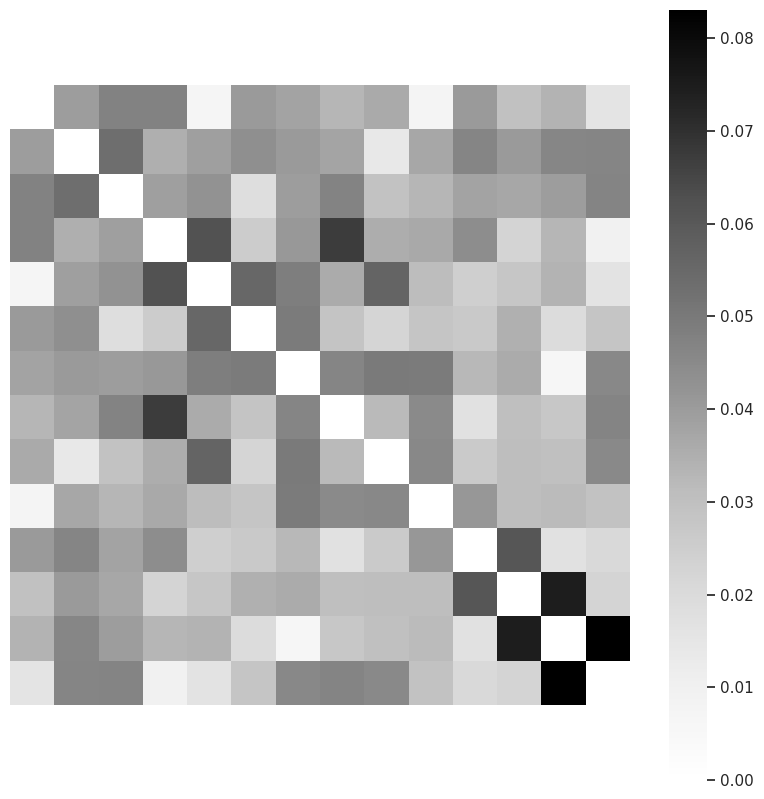

/tmp/tmphvyoel_w
3DMax for Genome Structure.
INSTRUCTION:
 (1) Input the file containing the parameters. 

Conversion to List Successful, New File = InputData_in_TupleFormat.txt
Number of points: 14
Number of constraints: 91
Max distance is: 11.737485367913745
Number of processors:1
Iteration 1, objective function:-48.56465, length of gradient 0.5271301
Iteration 2, objective function:-44.88332, length of gradient 0.6492961
Iteration 3, objective function:-41.12777, length of gradient 0.7838639
Iteration 4, objective function:-37.70617, length of gradient 0.9041017
Iteration 5, objective function:-35.39036, length of gradient 0.8795275
Iteration 6, objective function:-34.37905, length of gradient 0.6269500
Iteration 7, objective function:-33.90952, length of gradient 0.4055340
Iteration 8, objective function:-33.66116, length of gradient 0.2915346
Iteration 9, objective function:-33.52863, length of gradient 0.2123528
Iteration 10, objective function:-33.45477, length of gradient 0.157

Iteration 231, objective function:-32.46563, length of gradient 0.0434904
Iteration 232, objective function:-32.45916, length of gradient 0.0440691
Iteration 233, objective function:-32.45256, length of gradient 0.0445964
Iteration 234, objective function:-32.44585, length of gradient 0.0450655
Iteration 235, objective function:-32.43903, length of gradient 0.0454708
Iteration 236, objective function:-32.43215, length of gradient 0.0458077
Iteration 237, objective function:-32.42520, length of gradient 0.0460733
Iteration 238, objective function:-32.41823, length of gradient 0.0462659
Iteration 239, objective function:-32.41125, length of gradient 0.0463857
Iteration 240, objective function:-32.40428, length of gradient 0.0464344
Iteration 241, objective function:-32.39735, length of gradient 0.0464156
Iteration 242, objective function:-32.39046, length of gradient 0.0463344
Iteration 243, objective function:-32.38363, length of gradient 0.0461974
Iteration 244, objective function:-32.

Iteration 484, objective function:-31.90108, length of gradient 0.0080262
Iteration 485, objective function:-31.90089, length of gradient 0.0079638
Iteration 486, objective function:-31.90071, length of gradient 0.0079007
Iteration 487, objective function:-31.90052, length of gradient 0.0078368
Iteration 488, objective function:-31.90034, length of gradient 0.0077721
Iteration 489, objective function:-31.90016, length of gradient 0.0077067
Iteration 490, objective function:-31.89999, length of gradient 0.0076406
Iteration 491, objective function:-31.89982, length of gradient 0.0075737
Iteration 492, objective function:-31.89965, length of gradient 0.0075062
Iteration 493, objective function:-31.89949, length of gradient 0.0074379
Iteration 494, objective function:-31.89933, length of gradient 0.0073690
Iteration 495, objective function:-31.89917, length of gradient 0.0072994
Iteration 496, objective function:-31.89901, length of gradient 0.0072292
Iteration 497, objective function:-31.

Iteration 1, objective function:-48.52774, length of gradient 0.5229214
Iteration 2, objective function:-44.76452, length of gradient 0.6559778
Iteration 3, objective function:-40.97187, length of gradient 0.7973901
Iteration 4, objective function:-37.58131, length of gradient 0.9124083
Iteration 5, objective function:-35.41772, length of gradient 0.8616797
Iteration 6, objective function:-34.41764, length of gradient 0.5978961
Iteration 7, objective function:-33.92304, length of gradient 0.3930321
Iteration 8, objective function:-33.66538, length of gradient 0.2801294
Iteration 9, objective function:-33.51880, length of gradient 0.2113095
Iteration 10, objective function:-33.42247, length of gradient 0.1714660
Iteration 11, objective function:-33.35166, length of gradient 0.1472294
Iteration 12, objective function:-33.29632, length of gradient 0.1304278
Iteration 13, objective function:-33.25170, length of gradient 0.1174211
Iteration 14, objective function:-33.21496, length of gradie

Iteration 196, objective function:-31.58051, length of gradient 0.0660100
Iteration 197, objective function:-31.56785, length of gradient 0.0652333
Iteration 198, objective function:-31.55561, length of gradient 0.0642142
Iteration 199, objective function:-31.54381, length of gradient 0.0630606
Iteration 200, objective function:-31.53243, length of gradient 0.0618619
Iteration 201, objective function:-31.52145, length of gradient 0.0606799
Iteration 202, objective function:-31.51085, length of gradient 0.0595475
Iteration 203, objective function:-31.50059, length of gradient 0.0584735
Iteration 204, objective function:-31.49065, length of gradient 0.0574504
Iteration 205, objective function:-31.48102, length of gradient 0.0564623
Iteration 206, objective function:-31.47170, length of gradient 0.0554909
Iteration 207, objective function:-31.46269, length of gradient 0.0545199
Iteration 208, objective function:-31.45399, length of gradient 0.0535368
Iteration 209, objective function:-31.

Iteration 819, objective function:-31.08782, length of gradient 0.0020539
Iteration 820, objective function:-31.08781, length of gradient 0.0020242
Iteration 821, objective function:-31.08780, length of gradient 0.0019950
Iteration 822, objective function:-31.08778, length of gradient 0.0019665
Iteration 823, objective function:-31.08777, length of gradient 0.0019385
Iteration 824, objective function:-31.08776, length of gradient 0.0019111
Iteration 825, objective function:-31.08775, length of gradient 0.0018842
Iteration 826, objective function:-31.08774, length of gradient 0.0018578
Iteration 827, objective function:-31.08773, length of gradient 0.0018319
Iteration 828, objective function:-31.08772, length of gradient 0.0018066
Iteration 829, objective function:-31.08771, length of gradient 0.0017817
Iteration 830, objective function:-31.08770, length of gradient 0.0017572
Iteration 831, objective function:-31.08769, length of gradient 0.0017332
Iteration 832, objective function:-31.

Iteration 77, objective function:-32.39351, length of gradient 0.0724020
Iteration 78, objective function:-32.37758, length of gradient 0.0722286
Iteration 79, objective function:-32.36135, length of gradient 0.0725831
Iteration 80, objective function:-32.34463, length of gradient 0.0734315
Iteration 81, objective function:-32.32721, length of gradient 0.0747454
Iteration 82, objective function:-32.30892, length of gradient 0.0765004
Iteration 83, objective function:-32.28956, length of gradient 0.0786732
Iteration 84, objective function:-32.26894, length of gradient 0.0812389
Iteration 85, objective function:-32.24688, length of gradient 0.0841676
Iteration 86, objective function:-32.22320, length of gradient 0.0874197
Iteration 87, objective function:-32.19775, length of gradient 0.0909420
Iteration 88, objective function:-32.17040, length of gradient 0.0946635
Iteration 89, objective function:-32.14108, length of gradient 0.0984938
Iteration 90, objective function:-32.10980, length 

Iteration 747, objective function:-31.37578, length of gradient 0.0004751
Iteration 748, objective function:-31.37578, length of gradient 0.0004728
Iteration 749, objective function:-31.37578, length of gradient 0.0004706
Iteration 750, objective function:-31.37578, length of gradient 0.0004683
Iteration 751, objective function:-31.37578, length of gradient 0.0004661
Iteration 752, objective function:-31.37578, length of gradient 0.0004639
Iteration 753, objective function:-31.37578, length of gradient 0.0004616
Iteration 754, objective function:-31.37578, length of gradient 0.0004594
Iteration 755, objective function:-31.37578, length of gradient 0.0004572
Iteration 756, objective function:-31.37578, length of gradient 0.0004551
Iteration 757, objective function:-31.37578, length of gradient 0.0004529
Iteration 758, objective function:-31.37578, length of gradient 0.0004507
Iteration 759, objective function:-31.37578, length of gradient 0.0004486
Iteration 760, objective function:-31.

Iteration 105, objective function:-33.24854, length of gradient 0.1084856
Iteration 106, objective function:-33.21235, length of gradient 0.1065063
Iteration 107, objective function:-33.17769, length of gradient 0.1046242
Iteration 108, objective function:-33.14447, length of gradient 0.1028365
Iteration 109, objective function:-33.11260, length of gradient 0.1011147
Iteration 110, objective function:-33.08206, length of gradient 0.0994163
Iteration 111, objective function:-33.05282, length of gradient 0.0976941
Iteration 112, objective function:-33.02489, length of gradient 0.0959040
Iteration 113, objective function:-32.99828, length of gradient 0.0940099
Iteration 114, objective function:-32.97304, length of gradient 0.0919859
Iteration 115, objective function:-32.94918, length of gradient 0.0898173
Iteration 116, objective function:-32.92672, length of gradient 0.0875005
Iteration 117, objective function:-32.90569, length of gradient 0.0850414
Iteration 118, objective function:-32.

Iteration 429, objective function:-32.26615, length of gradient 0.0128336
Iteration 430, objective function:-32.26569, length of gradient 0.0125483
Iteration 431, objective function:-32.26525, length of gradient 0.0122690
Iteration 432, objective function:-32.26483, length of gradient 0.0119955
Iteration 433, objective function:-32.26443, length of gradient 0.0117275
Iteration 434, objective function:-32.26404, length of gradient 0.0114651
Iteration 435, objective function:-32.26367, length of gradient 0.0112080
Iteration 436, objective function:-32.26332, length of gradient 0.0109563
Iteration 437, objective function:-32.26298, length of gradient 0.0107097
Iteration 438, objective function:-32.26266, length of gradient 0.0104682
Iteration 439, objective function:-32.26235, length of gradient 0.0102317
Iteration 440, objective function:-32.26206, length of gradient 0.0100001
Iteration 441, objective function:-32.26178, length of gradient 0.0097733
Iteration 442, objective function:-32.

Iteration 373, objective function:-34.68340, length of gradient 0.0170312
Iteration 374, objective function:-34.68234, length of gradient 0.0161824
Iteration 375, objective function:-34.68139, length of gradient 0.0153746
Iteration 376, objective function:-34.68053, length of gradient 0.0146105
Iteration 377, objective function:-34.67976, length of gradient 0.0138920
Iteration 378, objective function:-34.67906, length of gradient 0.0132201
Iteration 379, objective function:-34.67843, length of gradient 0.0125950
Iteration 380, objective function:-34.67785, length of gradient 0.0120162
Iteration 381, objective function:-34.67732, length of gradient 0.0114827
Iteration 382, objective function:-34.67684, length of gradient 0.0109929
Iteration 383, objective function:-34.67640, length of gradient 0.0105448
Iteration 384, objective function:-34.67599, length of gradient 0.0101362
Iteration 385, objective function:-34.67561, length of gradient 0.0097649
Iteration 386, objective function:-34.

Iteration 37, objective function:-37.57421, length of gradient 0.0748678
Iteration 38, objective function:-37.55227, length of gradient 0.0720012
Iteration 39, objective function:-37.53229, length of gradient 0.0690420
Iteration 40, objective function:-37.51420, length of gradient 0.0660476
Iteration 41, objective function:-37.49788, length of gradient 0.0630768
Iteration 42, objective function:-37.48319, length of gradient 0.0601789
Iteration 43, objective function:-37.46998, length of gradient 0.0573891
Iteration 44, objective function:-37.45808, length of gradient 0.0547286
Iteration 45, objective function:-37.44737, length of gradient 0.0522082
Iteration 46, objective function:-37.43770, length of gradient 0.0498319
Iteration 47, objective function:-37.42896, length of gradient 0.0476001
Iteration 48, objective function:-37.42103, length of gradient 0.0455113
Iteration 49, objective function:-37.41382, length of gradient 0.0435628
Iteration 50, objective function:-37.40725, length 

Iteration 471, objective function:-39.71105, length of gradient 0.0004099
Iteration 472, objective function:-39.71105, length of gradient 0.0004087
Iteration 473, objective function:-39.71105, length of gradient 0.0004074
Iteration 474, objective function:-39.71105, length of gradient 0.0004062
Iteration 475, objective function:-39.71105, length of gradient 0.0004050
Iteration 476, objective function:-39.71105, length of gradient 0.0004038
Iteration 477, objective function:-39.71105, length of gradient 0.0004026
Iteration 478, objective function:-39.71105, length of gradient 0.0004014
Iteration 479, objective function:-39.71104, length of gradient 0.0004003
Iteration 480, objective function:-39.71104, length of gradient 0.0003991
Iteration 481, objective function:-39.71104, length of gradient 0.0003980
Iteration 1, objective function:-51.05403, length of gradient 0.4268673
Iteration 2, objective function:-48.73011, length of gradient 0.4755842
Iteration 3, objective function:-46.84881,

Iteration 91, objective function:-42.12591, length of gradient 0.0185972
Iteration 92, objective function:-42.12403, length of gradient 0.0182156
Iteration 93, objective function:-42.12225, length of gradient 0.0178193
Iteration 94, objective function:-42.12056, length of gradient 0.0174122
Iteration 95, objective function:-42.11896, length of gradient 0.0169979
Iteration 96, objective function:-42.11745, length of gradient 0.0165797
Iteration 97, objective function:-42.11603, length of gradient 0.0161610
Iteration 98, objective function:-42.11469, length of gradient 0.0157444
Iteration 99, objective function:-42.11342, length of gradient 0.0153326
Iteration 100, objective function:-42.11224, length of gradient 0.0149276
Iteration 101, objective function:-42.11112, length of gradient 0.0145313
Iteration 102, objective function:-42.11007, length of gradient 0.0141449
Iteration 103, objective function:-42.10908, length of gradient 0.0137697
Iteration 104, objective function:-42.10815, le

Iteration 253, objective function:-44.44245, length of gradient 0.0005252
Iteration 254, objective function:-44.44245, length of gradient 0.0005234
Iteration 255, objective function:-44.44245, length of gradient 0.0005215
Iteration 256, objective function:-44.44244, length of gradient 0.0005197
Iteration 257, objective function:-44.44244, length of gradient 0.0005179
Iteration 258, objective function:-44.44244, length of gradient 0.0005161
Iteration 259, objective function:-44.44244, length of gradient 0.0005143
Iteration 260, objective function:-44.44244, length of gradient 0.0005126
Iteration 261, objective function:-44.44244, length of gradient 0.0005109
Iteration 262, objective function:-44.44244, length of gradient 0.0005091
Iteration 263, objective function:-44.44243, length of gradient 0.0005074
Iteration 264, objective function:-44.44243, length of gradient 0.0005058
Iteration 265, objective function:-44.44243, length of gradient 0.0005041
Iteration 266, objective function:-44.

Iteration 229, objective function:-46.63165, length of gradient 0.0010452
Iteration 230, objective function:-46.63164, length of gradient 0.0010248
Iteration 231, objective function:-46.63164, length of gradient 0.0010048
Iteration 232, objective function:-46.63163, length of gradient 0.0009852
Iteration 233, objective function:-46.63162, length of gradient 0.0009660
Iteration 234, objective function:-46.63162, length of gradient 0.0009472
Iteration 235, objective function:-46.63161, length of gradient 0.0009287
Iteration 236, objective function:-46.63161, length of gradient 0.0009106
Iteration 237, objective function:-46.63160, length of gradient 0.0008929
Iteration 238, objective function:-46.63160, length of gradient 0.0008755
Iteration 239, objective function:-46.63159, length of gradient 0.0008585
Iteration 240, objective function:-46.63159, length of gradient 0.0008418
Iteration 241, objective function:-46.63158, length of gradient 0.0008254
Iteration 242, objective function:-46.

Iteration 262, objective function:-48.68656, length of gradient 0.0007846
Iteration 263, objective function:-48.68656, length of gradient 0.0007782
Iteration 264, objective function:-48.68655, length of gradient 0.0007719
Iteration 265, objective function:-48.68655, length of gradient 0.0007656
Iteration 266, objective function:-48.68654, length of gradient 0.0007594
Iteration 267, objective function:-48.68654, length of gradient 0.0007533
Iteration 268, objective function:-48.68653, length of gradient 0.0007473
Iteration 269, objective function:-48.68653, length of gradient 0.0007412
Iteration 270, objective function:-48.68652, length of gradient 0.0007353
Iteration 271, objective function:-48.68652, length of gradient 0.0007294
Iteration 272, objective function:-48.68651, length of gradient 0.0007236
Iteration 273, objective function:-48.68651, length of gradient 0.0007178
Iteration 274, objective function:-48.68651, length of gradient 0.0007121
Iteration 275, objective function:-48.

Iteration 684, objective function:-50.62745, length of gradient 0.0026380
Iteration 685, objective function:-50.62739, length of gradient 0.0026291
Iteration 686, objective function:-50.62734, length of gradient 0.0026203
Iteration 687, objective function:-50.62729, length of gradient 0.0026117
Iteration 688, objective function:-50.62724, length of gradient 0.0026031
Iteration 689, objective function:-50.62719, length of gradient 0.0025947
Iteration 690, objective function:-50.62714, length of gradient 0.0025864
Iteration 691, objective function:-50.62709, length of gradient 0.0025782
Iteration 692, objective function:-50.62704, length of gradient 0.0025701
Iteration 693, objective function:-50.62699, length of gradient 0.0025622
Iteration 694, objective function:-50.62694, length of gradient 0.0025543
Iteration 695, objective function:-50.62689, length of gradient 0.0025466
Iteration 696, objective function:-50.62685, length of gradient 0.0025390
Iteration 697, objective function:-50.

Iteration 141, objective function:-52.43003, length of gradient 0.0044476
Iteration 142, objective function:-52.42984, length of gradient 0.0043839
Iteration 143, objective function:-52.42966, length of gradient 0.0043208
Iteration 144, objective function:-52.42948, length of gradient 0.0042585
Iteration 145, objective function:-52.42931, length of gradient 0.0041969
Iteration 146, objective function:-52.42914, length of gradient 0.0041361
Iteration 147, objective function:-52.42898, length of gradient 0.0040759
Iteration 148, objective function:-52.42882, length of gradient 0.0040166
Iteration 149, objective function:-52.42866, length of gradient 0.0039580
Iteration 150, objective function:-52.42851, length of gradient 0.0039001
Iteration 151, objective function:-52.42837, length of gradient 0.0038431
Iteration 152, objective function:-52.42823, length of gradient 0.0037868
Iteration 153, objective function:-52.42809, length of gradient 0.0037313
Iteration 154, objective function:-52.

Iteration 239, objective function:-54.12630, length of gradient 0.0025212
Iteration 240, objective function:-54.12623, length of gradient 0.0025150
Iteration 241, objective function:-54.12616, length of gradient 0.0025090
Iteration 242, objective function:-54.12610, length of gradient 0.0025031
Iteration 243, objective function:-54.12603, length of gradient 0.0024974
Iteration 244, objective function:-54.12596, length of gradient 0.0024918
Iteration 245, objective function:-54.12590, length of gradient 0.0024863
Iteration 246, objective function:-54.12583, length of gradient 0.0024810
Iteration 247, objective function:-54.12577, length of gradient 0.0024758
Iteration 248, objective function:-54.12570, length of gradient 0.0024707
Iteration 249, objective function:-54.12564, length of gradient 0.0024657
Iteration 250, objective function:-54.12558, length of gradient 0.0024609
Iteration 251, objective function:-54.12551, length of gradient 0.0024561
Iteration 252, objective function:-54.

Iteration 248, objective function:-54.11639, length of gradient 0.0030786
Iteration 249, objective function:-54.11631, length of gradient 0.0030523
Iteration 250, objective function:-54.11624, length of gradient 0.0030263
Iteration 251, objective function:-54.11616, length of gradient 0.0030006
Iteration 252, objective function:-54.11608, length of gradient 0.0029753
Iteration 253, objective function:-54.11601, length of gradient 0.0029503
Iteration 254, objective function:-54.11594, length of gradient 0.0029256
Iteration 255, objective function:-54.11587, length of gradient 0.0029012
Iteration 256, objective function:-54.11579, length of gradient 0.0028771
Iteration 257, objective function:-54.11572, length of gradient 0.0028533
Iteration 258, objective function:-54.11566, length of gradient 0.0028298
Iteration 259, objective function:-54.11559, length of gradient 0.0028065
Iteration 260, objective function:-54.11552, length of gradient 0.0027836
Iteration 261, objective function:-54.

Iteration 448, objective function:-55.70189, length of gradient 0.0022540
Iteration 449, objective function:-55.70184, length of gradient 0.0022470
Iteration 450, objective function:-55.70180, length of gradient 0.0022400
Iteration 451, objective function:-55.70175, length of gradient 0.0022330
Iteration 452, objective function:-55.70171, length of gradient 0.0022260
Iteration 453, objective function:-55.70166, length of gradient 0.0022190
Iteration 454, objective function:-55.70162, length of gradient 0.0022121
Iteration 455, objective function:-55.70157, length of gradient 0.0022052
Iteration 456, objective function:-55.70153, length of gradient 0.0021983
Iteration 457, objective function:-55.70149, length of gradient 0.0021914
Iteration 458, objective function:-55.70144, length of gradient 0.0021846
Iteration 459, objective function:-55.70140, length of gradient 0.0021777
Iteration 460, objective function:-55.70136, length of gradient 0.0021709
Iteration 461, objective function:-55.

Iteration 215, objective function:-57.21655, length of gradient 0.0065397
Iteration 216, objective function:-57.21608, length of gradient 0.0065091
Iteration 217, objective function:-57.21562, length of gradient 0.0064785
Iteration 218, objective function:-57.21516, length of gradient 0.0064480
Iteration 219, objective function:-57.21471, length of gradient 0.0064176
Iteration 220, objective function:-57.21426, length of gradient 0.0063872
Iteration 221, objective function:-57.21382, length of gradient 0.0063568
Iteration 222, objective function:-57.21338, length of gradient 0.0063265
Iteration 223, objective function:-57.21294, length of gradient 0.0062963
Iteration 224, objective function:-57.21251, length of gradient 0.0062661
Iteration 225, objective function:-57.21208, length of gradient 0.0062360
Iteration 226, objective function:-57.21166, length of gradient 0.0062059
Iteration 227, objective function:-57.21124, length of gradient 0.0061759
Iteration 228, objective function:-57.

Iteration 161, objective function:-58.62351, length of gradient 0.0037978
Iteration 162, objective function:-58.62327, length of gradient 0.0038241
Iteration 163, objective function:-58.62303, length of gradient 0.0038503
Iteration 164, objective function:-58.62279, length of gradient 0.0038764
Iteration 165, objective function:-58.62255, length of gradient 0.0039025
Iteration 166, objective function:-58.62231, length of gradient 0.0039285
Iteration 167, objective function:-58.62206, length of gradient 0.0039545
Iteration 168, objective function:-58.62180, length of gradient 0.0039803
Iteration 169, objective function:-58.62155, length of gradient 0.0040061
Iteration 170, objective function:-58.62129, length of gradient 0.0040319
Iteration 171, objective function:-58.62103, length of gradient 0.0040575
Iteration 172, objective function:-58.62076, length of gradient 0.0040831
Iteration 173, objective function:-58.62050, length of gradient 0.0041085
Iteration 174, objective function:-58.

Iteration 32, objective function:-59.98530, length of gradient 0.0263429
Iteration 33, objective function:-59.98028, length of gradient 0.0250779
Iteration 34, objective function:-59.97573, length of gradient 0.0238828
Iteration 35, objective function:-59.97160, length of gradient 0.0227531
Iteration 36, objective function:-59.96786, length of gradient 0.0216851
Iteration 37, objective function:-59.96445, length of gradient 0.0206751
Iteration 38, objective function:-59.96134, length of gradient 0.0197198
Iteration 39, objective function:-59.95851, length of gradient 0.0188161
Iteration 40, objective function:-59.95593, length of gradient 0.0179612
Iteration 41, objective function:-59.95356, length of gradient 0.0171525
Iteration 42, objective function:-59.95140, length of gradient 0.0163874
Iteration 43, objective function:-59.94941, length of gradient 0.0156637
Iteration 44, objective function:-59.94758, length of gradient 0.0149792
Iteration 45, objective function:-59.94591, length 

Iteration 49, objective function:-33.33322, length of gradient 0.1288748
Iteration 50, objective function:-33.27882, length of gradient 0.1296676
Iteration 51, objective function:-33.22427, length of gradient 0.1300088
Iteration 52, objective function:-33.17008, length of gradient 0.1297623
Iteration 53, objective function:-33.11686, length of gradient 0.1288015
Iteration 54, objective function:-33.06532, length of gradient 0.1270321
Iteration 55, objective function:-33.01616, length of gradient 0.1244212
Iteration 56, objective function:-32.96997, length of gradient 0.1210166
Iteration 57, objective function:-32.92714, length of gradient 0.1169470
Iteration 58, objective function:-32.88788, length of gradient 0.1123995
Iteration 59, objective function:-32.85217, length of gradient 0.1075837
Iteration 60, objective function:-32.81985, length of gradient 0.1026968
Iteration 61, objective function:-32.79065, length of gradient 0.0979004
Iteration 62, objective function:-32.76425, length 

In [16]:
_draw(pseudo_bulk_hic[1], ignore_diag=True)
# Calculate_chromatin_conformation(pseudo_bulk_hic[1]*1000, 'Late({})'.format(gene_name))

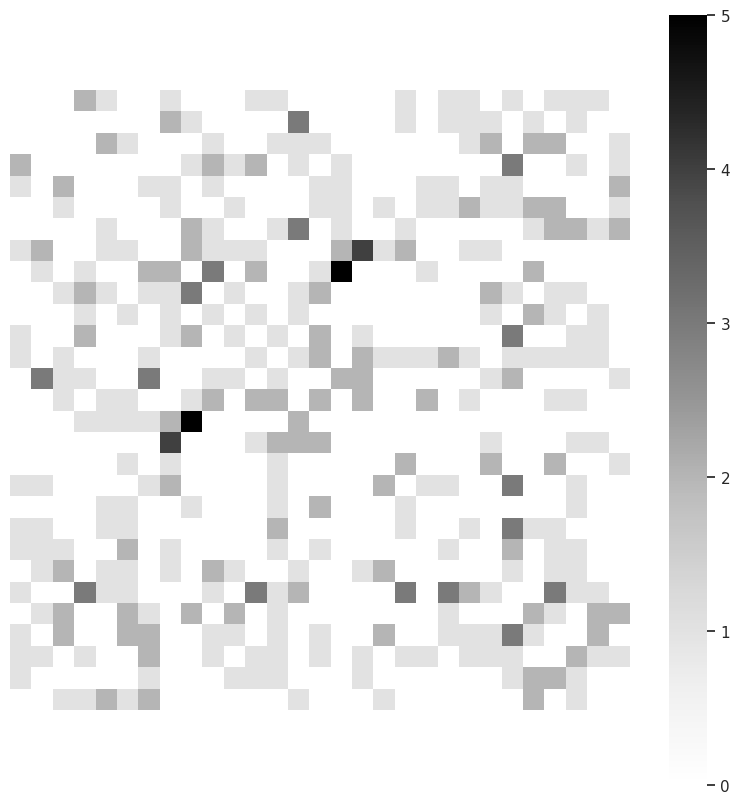

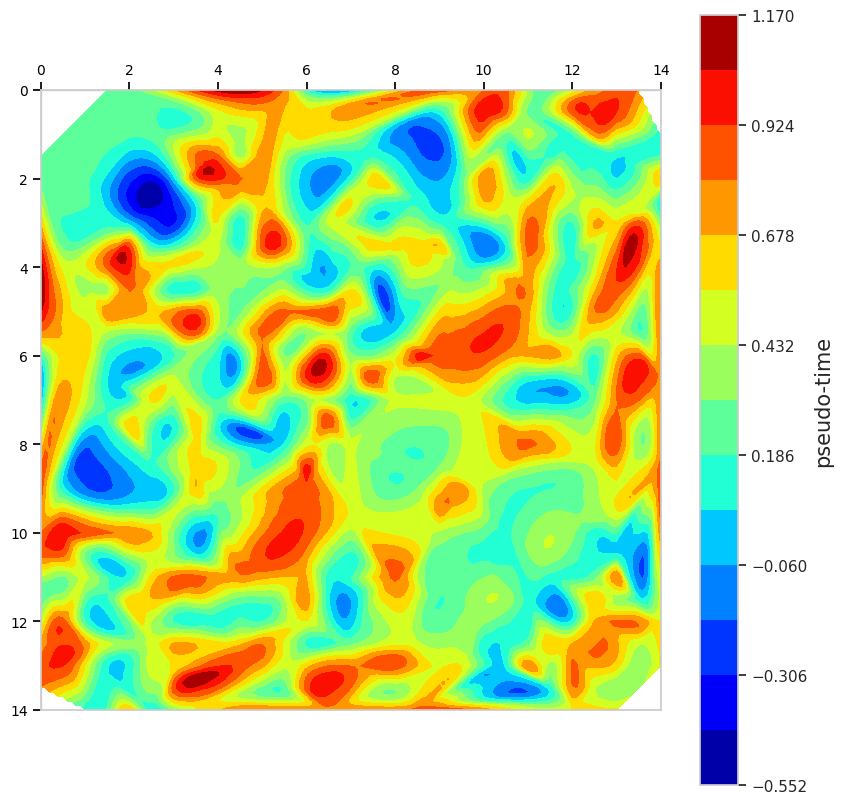

In [17]:
from scipy import interpolate

x = np.linspace(0, _len, _len*2+1)
y = np.linspace(0, _len, _len*2+1)
yy, xx = np.meshgrid(x, y)

def _norm(_decimal):
    if _decimal > 0.5:
        if 1 - _decimal >= _decimal - 0.5:
            return 0.5
        else:
            return 1
    else:
        if 0.5 - _decimal >= _decimal:
            return 0
        else:
            return 0.5

_count = np.zeros(xx.shape)
_value = np.zeros(xx.shape)
for i in range(len(_scatter_xs)):
    _decimal_x, _decimal_y = _scatter_xs[i] - int(_scatter_xs[i]), _scatter_ys[i] - int(_scatter_ys[i])
    _x, _y = int(_scatter_xs[i]) + _norm(_decimal_x), int(_scatter_ys[i]) + _norm(_decimal_y)
    _value[int(_x/0.5), int(_y/0.5)] += _pseudotimes[i]
    _count[int(_x/0.5), int(_y/0.5)] += 1

for i in range(_value.shape[0]):
    for j in range(_value.shape[1]):
        if _count[i, j] != 0:
            _value[i, j] /= _count[i, j]

_value[_count==0] = np.nan
_draw(_count, title='number of interaction occurrences({})'.format(gene_name))




set_plt(figsize=(10, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

xx[_count==0] = yy[_count==0] = np.nan
xx, yy, new_value = xx.ravel(), yy.ravel(), _value.ravel()
xx, yy, new_value = list(xx[~np.isnan(xx)]), list(yy[~np.isnan(yy)]), list(new_value[~np.isnan(new_value)])

xnew = np.linspace(0, _len, _len*10+1)
ynew = np.linspace(0, _len, _len*10+1)
new_value = interpolate.griddata((xx, yy), new_value, (xnew[None,:], ynew[:,None]), method='cubic')

levels = np.linspace(min(new_value[~np.isnan(new_value)]), max(new_value[~np.isnan(new_value)]), 15)
cs = ax.contourf(xnew, ynew, new_value, levels=levels, cmap=plt.cm.jet)
cbar = plt.colorbar(cs)
cbar.set_label('pseudo-time', rotation=90, fontsize=15) # gas fraction

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')
plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['small'])

plt.savefig(
    '/lmh_data/work/SEE/analyse/figure_file/interactions distribution({}).pdf'.format(gene_name),
    format='pdf', bbox_inches='tight')

plt.show()